### Go to this given URL and solve the following questions
    URL: https://www.youtube.com/@PW-Foundation/videos

    Q1. Write a python program to extract the video URL of the first five videos.

    Q2. Write a python program to extract the URL of the video thumbnails of the first five videos.

    Q3. Write a python program to extract the title of the first five videos.

    Q4. Write a python program to extract the number of views of the first five videos.

    Q5. Write a python program to extract the time of posting of video for the first five videos.

### Answer :

    I've developed the flask webapp to retrive youtube channel Videos data, sorted them as per their published date, saved it in csv file

    redirected, wrote the csv data to html website

    used some concepts like async to increase the speed of execution.

aws link to test it : http://flaskwebapp-env.eba-b3thfmj4.us-east-1.elasticbeanstalk.com/

github_project_link : https://github.com/RamaManohar5/FlaskWebAppPackage_AWS

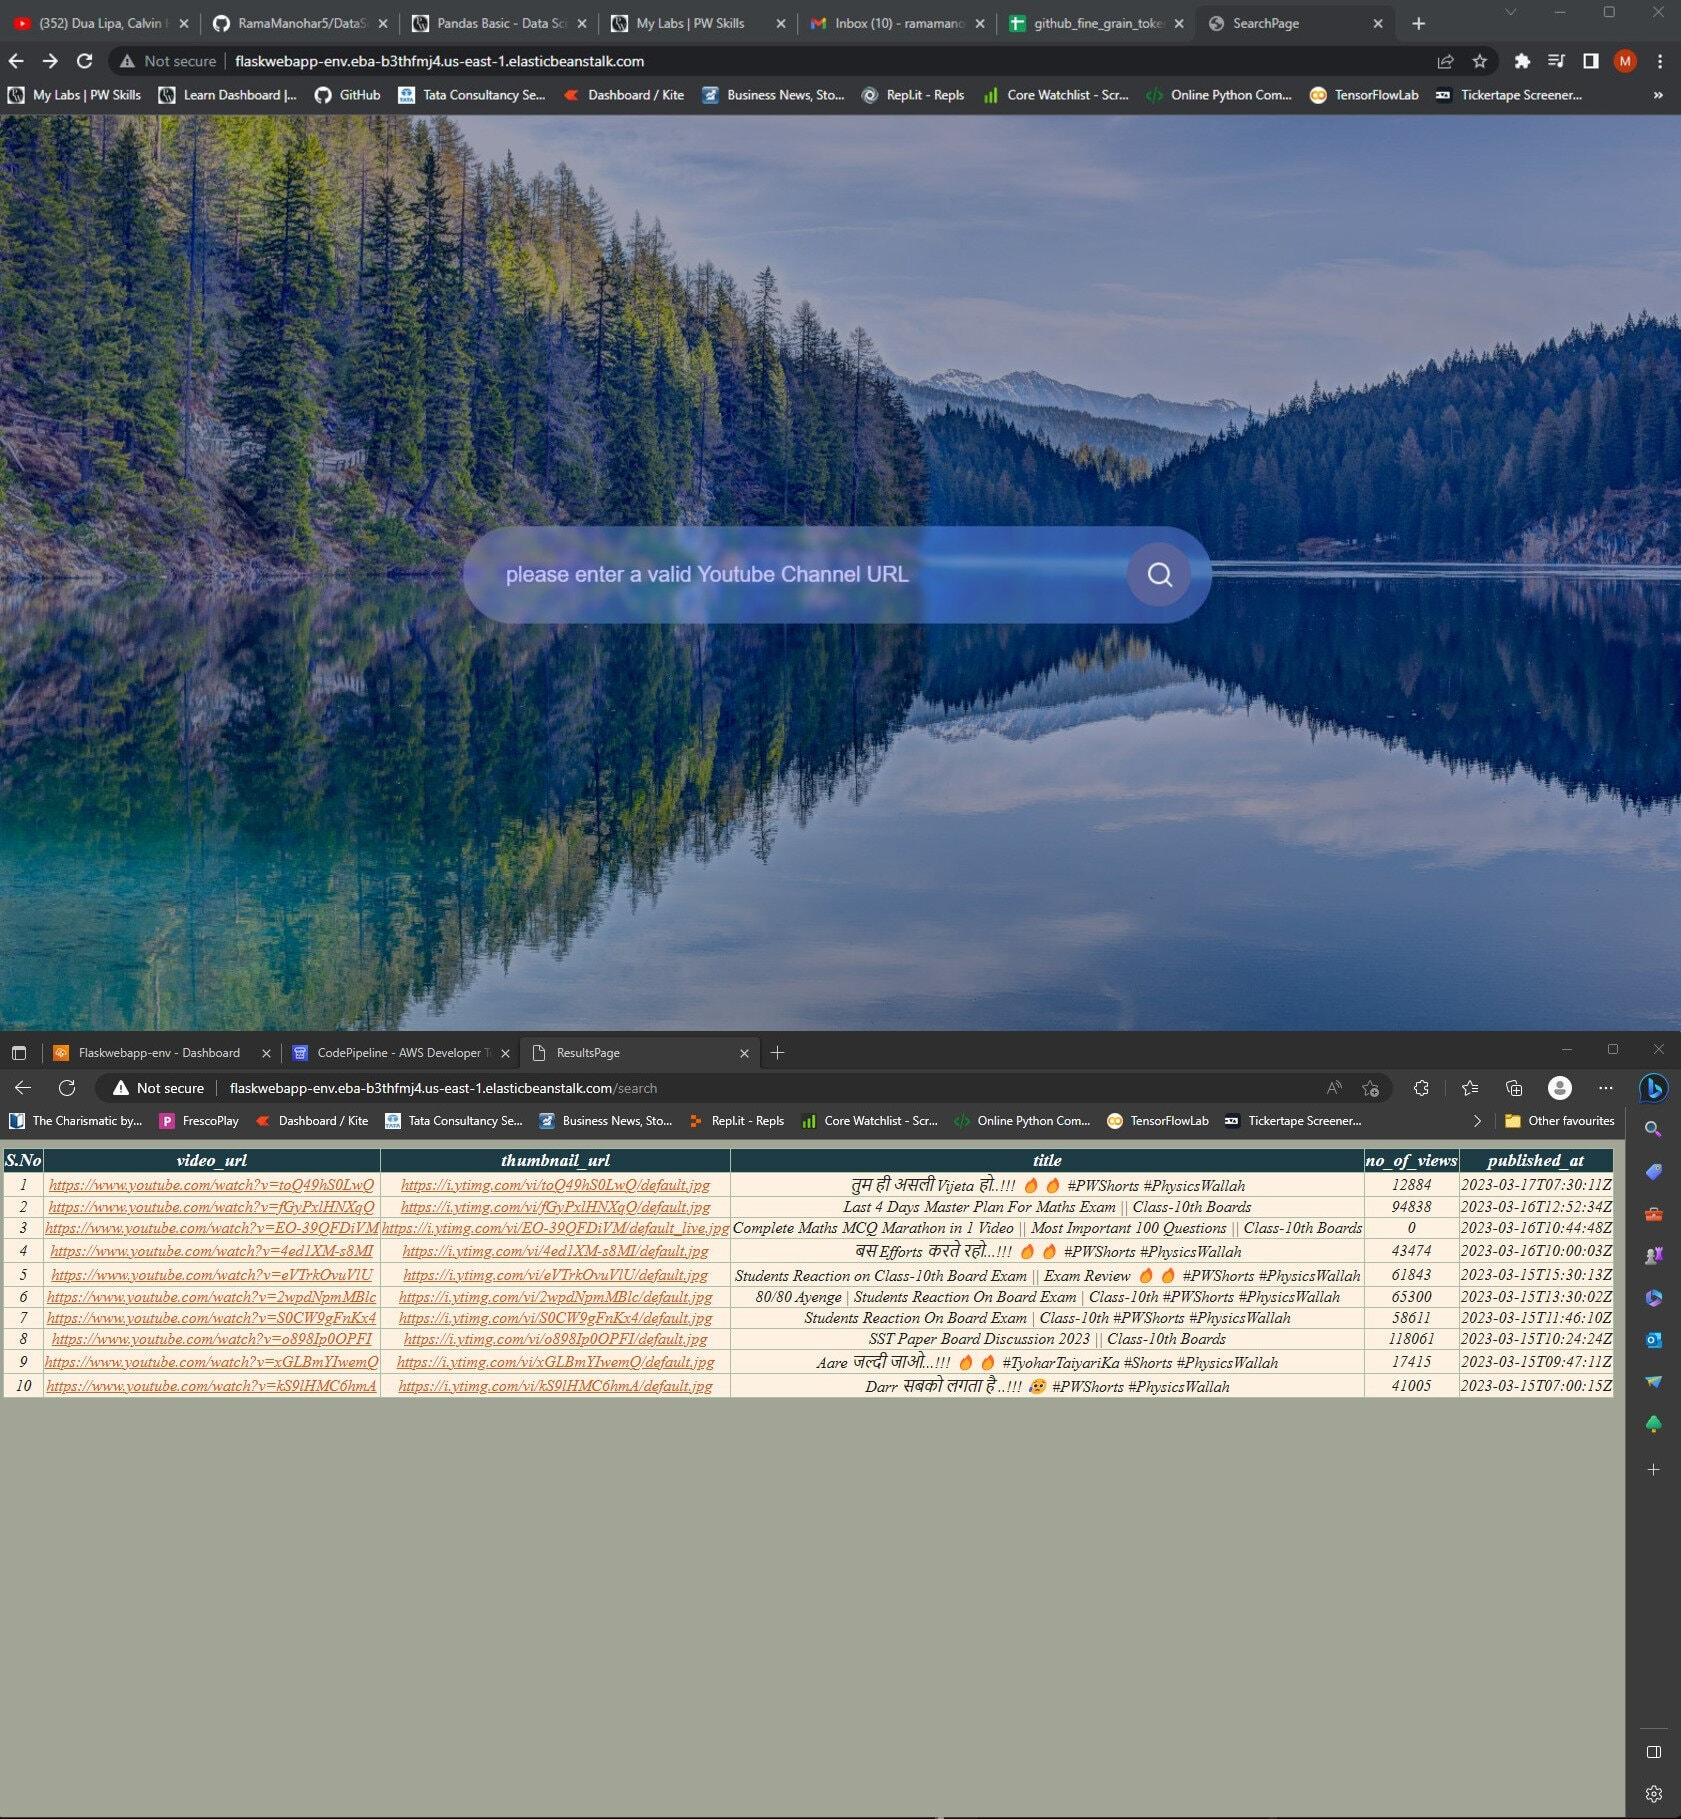

### Code

In [1]:
from flask import Blueprint, render_template, request
from flask_cors import CORS, cross_origin
import asyncio
import aiohttp
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request
import json
import logging
logging.basicConfig(filename='scraper.log', level=logging.INFO)
import os
import csv
import time
from webAPI.key import key

# Initialize the API component.
views = Blueprint("views", __name__)


# routes
@views.route('/')
def base():
    return render_template('index.html')


@views.route('/search', methods=['GET', 'POST'])
def get_content():
    if request.method == 'POST':
        try:
            channel_url = request.form['content']
            start_time = time.time()
            # initializing the asynchronisation
            csv_file = asyncio.run(fetch_channel_data(channel_url))
            stop_time = time.time()
            print(f"time taken {stop_time - start_time} seconds")
            # csv object
            with open(csv_file, 'r', encoding='UTF-8') as file:
                reader = csv.reader(file)
                header = next(reader)
                # rendering the html
                return render_template('results.html', header=header, rows=reader)

        except Exception as e:
            logging.INFO(e)


# method to get video_ids

def get_video_ids(channel_url):
    print('entered get_videos_method')
    try:
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) "
                          "Chrome/47.0.2526.106 Safari/537.36"}
        req = Request(channel_url, headers=headers)
        response = urlopen(req)
        soup = BeautifulSoup(urlopen(req), features="html.parser")
        # channelID from metadata
        channel_id = soup.find_all('meta', {'itemprop': 'channelId'})[0].attrs['content']
        # count set to 25, api will fetch javascript for those videos throug API
        channel_id_url = f"https://www.googleapis.com/youtube/v3/search?key={key}&channelId={channel_id}&part" \
                         f"=snippet,id&order=date&maxResults=10"
        # open the connection through google api
        resp = urlopen(channel_id_url)
        # converts the response into json
        response_data = json.load(resp)
        # closes the connection
        resp.close()
        # data is in dict format & fetch unique videoId of each video from the channel page.
        videos_ids = list()
        for item in response_data['items']:
            for k in (item['id']).keys():
                if k == 'videoId':
                    videos_ids.append(item['id']['videoId'])

        return videos_ids

    except Exception as e:
        logging.INFO(e)


# generating async tasks
def generate_tasks(videos_ids, session):
    api_url = "https://www.googleapis.com/youtube/v3/videos?part=snippet%2CcontentDetails%2Cstatistics&id={}&key={}"
    async_tasks = []

    for video_id in videos_ids:
        # create session_task for each videoID
        session_task = session.get(api_url.format(video_id, key), ssl=False)
        # asyncio_task for each session_task
        async_task = asyncio.create_task(session_task)
        async_tasks.append(async_task)
    return async_tasks


# main async method

async def fetch_channel_data(channel_url):
    print('entered asyncio main method')
    video_url_string = 'https://www.youtube.com/watch?v='

    # collects response data for all video_ids
    contents = list()
    dict_contents = list()
    # getting video_ids from the given channel
    videos_ids = get_video_ids(channel_url)

    print('entered asyncio main method again after getting videos_ids')

    print(videos_ids)
    # asynchronisation
    print('async tasks iniatiation')
    async with aiohttp.ClientSession() as session:
        # creating a list of async tasks for each video_id of channel videos
        async_tasks = generate_tasks(videos_ids, session)
        # gather all async tasks while awaiting and assign it to the iterator
        raw_responses = await asyncio.gather(*async_tasks)
        for raw_response in raw_responses:
            # jsonify the response
            response = await raw_response.json()
            contents.append(response)
    print(f'async tasks completed {len(async_tasks)} and raw_responses {len(raw_responses)} contents {len(contents)}')
    #  prepare the data in dictionary format from the contents with the requiered fields
    for index, content in enumerate(contents):

        temp_dict = dict()

        for item in content['items']:
            temp_dict['S.No'] = index + 1
            temp_dict['video_url'] = "{}{}".format(video_url_string, item['id'])
            temp_dict['thumbnail_url'] = item['snippet']['thumbnails']['default']['url']
            temp_dict['title'] = item['snippet']['title']
            temp_dict['no_of_views'] = item['statistics']['viewCount']
            temp_dict['published_at'] = item['snippet']['publishedAt']
            # appending the dictionary as a single row
            dict_contents.append(temp_dict)
            # sorting the data in the list based on publishing time
            sorted(dict_contents, key=lambda x: x['published_at'])


    # writing the data to csv using csv object
    folder_path = os.getcwd()
    csv_file_name = channel_url.split('/')[3] + '.csv'
    csv_file = f"{folder_path}/{csv_file_name}"

    #delete the residual csv_files
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            os.remove(f"{folder_path}/{filename}")

    # headers for the csv sheet
    field_names = ["S.No", "video_url", "thumbnail_url", "title", "no_of_views", 'published_at']
    with open(csv_file, 'w', encoding='UTF-8') as file:
        # csv dictionary object
        dict_writer = csv.DictWriter(file, field_names)
        # writing the header first
        dict_writer.writeheader()

        # writing the rest of the data as rows
        for row_dict in dict_contents:
            dict_writer.writerow(row_dict)

        # return response_data
        return csv_file

ModuleNotFoundError: No module named 'flask'